# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 501.4/501.4 KB 11.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 KB 39.1 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 KB 28.7 MB/s eta 0:00:00
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.10.2 requires ruamel-yaml, which is not installed.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 KB 10.7 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [11]:
client = MongoClient(mongod_connect)
db = client.ia340 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [12]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [10]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [11]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

AttributeError: module 'tweepy' has no attribute 'StreamListener'

## Use the REST API to Collect Tweets

Authorize the REST API 

In [13]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [14]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5243316,-77.7727589,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [15]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Fri Nov 18 22:32:10 +0000 2022'
'Fri Nov 18 22:05:00 +0000 2022'
'Fri Nov 18 22:01:17 +0000 2022'
'Fri Nov 18 22:01:13 +0000 2022'
'Fri Nov 18 21:53:59 +0000 2022'
'Fri Nov 18 21:52:45 +0000 2022'
'Fri Nov 18 21:49:56 +0000 2022'
'Fri Nov 18 21:49:29 +0000 2022'
'Fri Nov 18 21:46:02 +0000 2022'
'Fri Nov 18 21:44:58 +0000 2022'
'Fri Nov 18 21:43:14 +0000 2022'
'Fri Nov 18 21:42:35 +0000 2022'
'Fri Nov 18 21:39:47 +0000 2022'
'Fri Nov 18 21:35:26 +0000 2022'
'Fri Nov 18 21:31:47 +0000 2022'
'Fri Nov 18 21:25:48 +0000 2022'
'Fri Nov 18 21:20:14 +0000 2022'
'Fri Nov 18 21:19:07 +0000 2022'
'Fri Nov 18 21:16:48 +0000 2022'
'Fri Nov 18 21:14:16 +0000 2022'
'Fri Nov 18 20:58:31 +0000 2022'
'Fri Nov 18 20:49:20 +0000 2022'
'Fri Nov 18 20:45:29 +0000 2022'
'Fri Nov 18 20:45:01 +0000 2022'
'Fri Nov 18 20:27:08 +0000 2022'
'Fri Nov 18 20:19:40 +0000 2022'
'Fri Nov 18 20:16:47 +0000 2022'
'Fri Nov 18 20:06:08 +0000 2022'
'Fri Nov 18 20:01:25 +0000 2022'
'Fri Nov 18 19:54:13 +0000 2022'
'Fri Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [16]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Fri Nov 18 14:07:25 +0000 2022'
'Fri Nov 18 14:05:18 +0000 2022'
'Fri Nov 18 14:02:54 +0000 2022'
'Fri Nov 18 14:00:06 +0000 2022'
'Fri Nov 18 14:00:01 +0000 2022'
'Fri Nov 18 13:20:09 +0000 2022'
'Fri Nov 18 13:18:24 +0000 2022'
'Fri Nov 18 13:18:09 +0000 2022'
'Fri Nov 18 13:12:27 +0000 2022'
'Fri Nov 18 13:02:59 +0000 2022'
'Fri Nov 18 13:01:28 +0000 2022'
'Fri Nov 18 13:01:03 +0000 2022'
'Fri Nov 18 13:00:03 +0000 2022'
'Fri Nov 18 12:41:00 +0000 2022'
'Fri Nov 18 11:00:05 +0000 2022'
'Fri Nov 18 10:46:49 +0000 2022'
'Fri Nov 18 10:30:04 +0000 2022'
'Fri Nov 18 10:30:04 +0000 2022'
'Fri Nov 18 09:15:00 +0000 2022'
'Fri Nov 18 08:05:46 +0000 2022'
'Fri Nov 18 07:19:49 +0000 2022'
'Fri Nov 18 07:02:48 +0000 2022'
'Fri Nov 18 04:00:00 +0000 2022'
'Fri Nov 18 03:55:24 +0000 2022'
'Fri Nov 18 03:18:14 +0000 2022'
'Fri Nov 18 02:32:18 +0000 2022'
'Fri Nov 18 01:52:09 +0000 2022'
'Fri Nov 18 01:46:19 +0000 2022'
'Fri Nov 18 01:08:46 +0000 2022'
'Fri Nov 18 01:07:01 +0000 2022'
'Fri Nov 1

'Wed Nov 16 15:37:57 +0000 2022'
'Wed Nov 16 15:37:20 +0000 2022'
'Wed Nov 16 15:08:02 +0000 2022'
'Wed Nov 16 15:05:46 +0000 2022'
'Wed Nov 16 15:02:46 +0000 2022'
'Wed Nov 16 15:02:31 +0000 2022'
'Wed Nov 16 15:00:29 +0000 2022'
'Wed Nov 16 14:52:21 +0000 2022'
'Wed Nov 16 14:48:04 +0000 2022'
'Wed Nov 16 14:38:19 +0000 2022'
'Wed Nov 16 14:32:04 +0000 2022'
'Wed Nov 16 14:30:13 +0000 2022'
'Wed Nov 16 14:05:33 +0000 2022'
'Wed Nov 16 14:02:32 +0000 2022'
'Wed Nov 16 14:01:40 +0000 2022'
'Wed Nov 16 14:00:20 +0000 2022'
'Wed Nov 16 13:51:32 +0000 2022'
'Wed Nov 16 13:30:09 +0000 2022'
'Wed Nov 16 13:30:00 +0000 2022'
'Wed Nov 16 13:23:00 +0000 2022'
'Wed Nov 16 13:14:48 +0000 2022'
'Wed Nov 16 13:13:57 +0000 2022'
'Wed Nov 16 13:10:12 +0000 2022'
'Wed Nov 16 13:09:05 +0000 2022'
'Wed Nov 16 13:00:04 +0000 2022'
'Wed Nov 16 12:02:03 +0000 2022'
'Wed Nov 16 11:26:41 +0000 2022'
'Wed Nov 16 11:01:56 +0000 2022'
'Wed Nov 16 10:30:06 +0000 2022'
'Wed Nov 16 10:30:05 +0000 2022'
'Wed Nov 1

'Mon Nov 14 16:30:12 +0000 2022'
'Mon Nov 14 16:30:00 +0000 2022'
'Mon Nov 14 16:16:28 +0000 2022'
'Mon Nov 14 16:13:15 +0000 2022'
'Mon Nov 14 16:11:03 +0000 2022'
'Mon Nov 14 16:09:30 +0000 2022'
'Mon Nov 14 16:00:00 +0000 2022'
'Mon Nov 14 15:56:46 +0000 2022'
'Mon Nov 14 15:49:43 +0000 2022'
'Mon Nov 14 15:48:37 +0000 2022'
'Mon Nov 14 15:44:53 +0000 2022'
'Mon Nov 14 15:44:10 +0000 2022'
'Mon Nov 14 15:26:01 +0000 2022'
'Mon Nov 14 15:21:03 +0000 2022'
'Mon Nov 14 15:18:29 +0000 2022'
'Mon Nov 14 15:17:32 +0000 2022'
'Mon Nov 14 15:16:28 +0000 2022'
'Mon Nov 14 15:14:56 +0000 2022'
'Mon Nov 14 15:13:49 +0000 2022'
'Mon Nov 14 15:09:14 +0000 2022'
'Mon Nov 14 15:03:00 +0000 2022'
'Mon Nov 14 15:01:13 +0000 2022'
'Mon Nov 14 15:00:10 +0000 2022'
'Mon Nov 14 15:00:00 +0000 2022'
'Mon Nov 14 14:58:13 +0000 2022'
'Mon Nov 14 14:52:13 +0000 2022'
'Mon Nov 14 14:43:18 +0000 2022'
'Mon Nov 14 14:23:23 +0000 2022'
'Mon Nov 14 14:15:58 +0000 2022'
'Mon Nov 14 14:12:32 +0000 2022'
'Mon Nov 1

'Fri Nov 11 15:15:15 +0000 2022'
'Fri Nov 11 15:12:10 +0000 2022'
'Fri Nov 11 15:00:22 +0000 2022'
'Fri Nov 11 14:51:08 +0000 2022'
'Fri Nov 11 14:37:04 +0000 2022'
'Fri Nov 11 14:30:06 +0000 2022'
'Fri Nov 11 14:25:58 +0000 2022'
'Fri Nov 11 14:25:13 +0000 2022'
'Fri Nov 11 14:25:05 +0000 2022'
'Fri Nov 11 14:22:45 +0000 2022'
'Fri Nov 11 14:00:00 +0000 2022'
'Fri Nov 11 13:54:58 +0000 2022'
'Fri Nov 11 13:47:44 +0000 2022'
'Fri Nov 11 13:42:04 +0000 2022'
'Fri Nov 11 13:35:59 +0000 2022'
'Fri Nov 11 13:20:15 +0000 2022'
'Fri Nov 11 12:51:35 +0000 2022'
'Fri Nov 11 11:38:50 +0000 2022'
'Fri Nov 11 11:12:05 +0000 2022'
'Fri Nov 11 10:40:48 +0000 2022'
'Fri Nov 11 10:30:05 +0000 2022'
'Fri Nov 11 10:30:05 +0000 2022'
'Fri Nov 11 10:30:04 +0000 2022'
'Fri Nov 11 08:33:19 +0000 2022'
'Fri Nov 11 08:25:01 +0000 2022'
'Fri Nov 11 07:23:45 +0000 2022'
'Fri Nov 11 06:46:28 +0000 2022'
'Fri Nov 11 04:00:00 +0000 2022'
'Fri Nov 11 03:18:06 +0000 2022'
'Fri Nov 11 02:02:15 +0000 2022'
'Fri Nov 1

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [17]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

1014
516


Create a text index and print the Tweets containing specific keywords. 

In [18]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [19]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [20]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: University of California Health
text: 3/7  9 #COVID19 @UofCAHealth inpatients are on a ventilator. 0 COVID19 inpatients are on extracorporeal membrane ox… https://t.co/Y4UhTYN0D5
----
name: Absolut.LIBRA
text: Whoopi has #COVID19 #TheView
----
name: Cheryl Cunha
text: @mikepompeo And they don't need mandatory Covid19 vaccines.
----
name: CryDiego
text: @SethDillon @MattWalshBlog Just think of the trillions for COVID19
----
name: ████ Tech Savvy ████
text: #IYKYK #COVID19 https://t.co/TJ3eehZsBu
----
name: Oscar Cingolani, M.D.
text: #COVID19 #covidusa https://t.co/rvFeovbHqN
----
name: 757 Progressive™️🆘🦠🇺🇸🌏🔥
text: 🧵 on the #PermanentPandemic of #COVID19 https://t.co/5JN030xSvM
----
name: Erik Glasser
text: #Simpsons #COVID19 #planned https://t.co/Me6LRnXI3w
----
name: 757 Progressive™️🆘🦠🇺🇸🌏🔥
text: #CovidIsNotOver #COVID19 #PermanentPandemic https://t.co/cdZdSq94TT
----
name: Marcus
text: #Covid19 #GameOver #JusticePourLesSuspendus https://t.co/Pei3doY52h


In [21]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [23]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status
0,637808ee5ad78b7f0a9d6b41,Mon Nov 14 17:27:34 +0000 2022,1592207627312066560,1592207627312066560,3/7 9 #COVID19 @UofCAHealth inpatients are on...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.592208e+18,...,0,1,False,False,False,en,NaN,NaN,NaN,NaN
1,637808ec5ad78b7f0a9d6ac1,Tue Nov 15 16:02:33 +0000 2022,1592548619999399936,1592548619999399936,Whoopi has #COVID19 #TheView,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
2,637808f25ad78b7f0a9d6c0c,Fri Nov 11 23:38:10 +0000 2022,1591213727281733633,1591213727281733633,@mikepompeo And they don't need mandatory Covi...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.591165e+18,...,0,1,False,False,NaN,en,NaN,NaN,NaN,NaN
3,637808f05ad78b7f0a9d6b8a,Mon Nov 14 06:47:11 +0000 2022,1592046468420210689,1592046468420210689,@SethDillon @MattWalshBlog Just think of the t...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.591993e+18,...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
4,637808e95ad78b7f0a9d6a49,Wed Nov 16 16:48:48 +0000 2022,1592922646219395073,1592922646219395073,#IYKYK #COVID19 https://t.co/TJ3eehZsBu,False,"{'hashtags': [{'text': 'IYKYK', 'indices': [0,...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,False,und,"{'media': [{'id': 1592922640867532800, 'id_str...",NaN,NaN,NaN
5,637808e75ad78b7f0a9d69e2,Thu Nov 17 13:14:00 +0000 2022,1593230979040423937,1593230979040423937,#COVID19 #covidusa https://t.co/rvFeovbHqN,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1,7,False,False,False,und,"{'media': [{'id': 1593230975827329025, 'id_str...",NaN,NaN,NaN
6,637808f55ad78b7f0a9d6c9e,Thu Nov 10 17:25:09 +0000 2022,1590757466249527296,1590757466249527296,🧵 on the #PermanentPandemic of #COVID19 https:...,False,"{'hashtags': [{'text': 'PermanentPandemic', 'i...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,0,False,False,False,en,NaN,1.590711e+18,1590710969516580865,{'created_at': 'Thu Nov 10 14:20:23 +0000 2022...
7,637808f45ad78b7f0a9d6c6d,Fri Nov 11 01:01:30 +0000 2022,1590872311632396288,1590872311632396288,#Simpsons #COVID19 #planned https://t.co/Me6LR...,False,"{'hashtags': [{'text': 'Simpsons', 'indices': ...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,1,False,False,False,und,NaN,1.590724e+18,1590723817541840896,{'created_at': 'Thu Nov 10 15:11:26 +0000 2022...
8,637808f25ad78b7f0a9d6c04,Sat Nov 12 03:31:52 +0000 2022,1591272541523390465,1591272541523390465,#CovidIsNotOver #COVID19 #PermanentPandemic ht...,False,"{'hashtags': [{'text': 'CovidIsNotOver', 'indi...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,1,False,False,False,und,NaN,1.591272e+18,1591272011728556033,{'created_at': 'Sat Nov 12 03:29:46 +0000 2022...
9,637808f25ad78b7f0a9d6bff,Sat Nov 12 10:19:59 +0000 2022,1591375247038873601,1591375247038873601,#Covid19 #GameOver #JusticePourLesSuspendus ht...,False,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_languag

<AxesSubplot:>

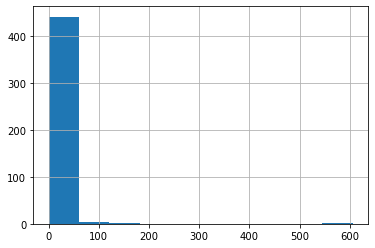

In [25]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count